In [43]:
# 03 — Tree-Based Model (XGBoost)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score

from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping

df = pd.read_csv("creditcard.csv")
cols = list(df.columns)

label_col = "Class" if "Class" in cols else "class"
time_col  = "Time"  if "Time"  in cols else "time"
amount_col= "Amount" if "Amount" in cols else "amount"

df[label_col] = pd.to_numeric(df[label_col], errors="coerce").fillna(0).astype(int)

X = df.drop(columns=[label_col])
y = df[label_col].astype(int)
amount_all = df[amount_col].astype(float).values

X_train, X_test, y_train, y_test, amt_train, amt_test = train_test_split(
    X, y, amount_all, test_size=0.2, random_state=42, stratify=y
)

print("Train fraud rate:", y_train.mean())
print("Test  fraud rate:", y_test.mean())

Train fraud rate: 0.001729245759178389
Test  fraud rate: 0.0017204452090867595


In [45]:
# Handle imbalance: scale_pos_weight = #neg / #pos
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / max(pos, 1)
print("scale_pos_weight:", scale_pos_weight)

scale_pos_weight: 577.2868020304569


In [47]:
# Train/val split for early stopping
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

xgb = XGBClassifier(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    reg_alpha=0.0,
    reg_lambda=1.0,
    gamma=0.0,
    objective="binary:logistic",
    eval_metric="aucpr",
    scale_pos_weight=scale_pos_weight,
    tree_method="hist",
    random_state=42
)

xgb.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    verbose=50
)

proba_test = xgb.predict_proba(X_test)[:, 1]

pr_auc = average_precision_score(y_test, proba_test)
roc_auc = roc_auc_score(y_test, proba_test)

print(f"XGBoost PR-AUC (Average Precision): {pr_auc:.4f}")
print(f"XGBoost ROC-AUC: {roc_auc:.4f}")

[0]	validation_0-aucpr:0.11459
[50]	validation_0-aucpr:0.70748
[100]	validation_0-aucpr:0.68544
[150]	validation_0-aucpr:0.73543
[200]	validation_0-aucpr:0.79298
[250]	validation_0-aucpr:0.80088
[300]	validation_0-aucpr:0.80836
[350]	validation_0-aucpr:0.80731
[400]	validation_0-aucpr:0.81054
[450]	validation_0-aucpr:0.81570
[500]	validation_0-aucpr:0.82099
[550]	validation_0-aucpr:0.82715
[600]	validation_0-aucpr:0.82933
[650]	validation_0-aucpr:0.83227
[700]	validation_0-aucpr:0.83551
[750]	validation_0-aucpr:0.83752
[800]	validation_0-aucpr:0.83770
[850]	validation_0-aucpr:0.83845
[900]	validation_0-aucpr:0.83890
[950]	validation_0-aucpr:0.83956
[1000]	validation_0-aucpr:0.84010
[1050]	validation_0-aucpr:0.84137
[1100]	validation_0-aucpr:0.84194
[1150]	validation_0-aucpr:0.84247
[1200]	validation_0-aucpr:0.84296
[1250]	validation_0-aucpr:0.84305
[1300]	validation_0-aucpr:0.84261
[1350]	validation_0-aucpr:0.84306
[1400]	validation_0-aucpr:0.84343
[1450]	validation_0-aucpr:0.84295
[15

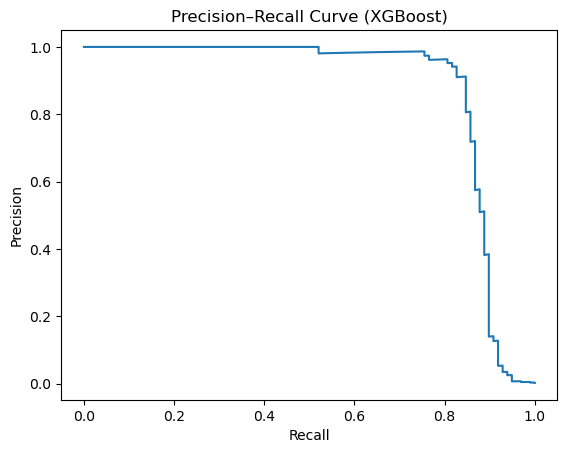

In [49]:
# PR curve
precision, recall, _ = precision_recall_curve(y_test, proba_test)

plt.figure()
plt.plot(recall, precision)
plt.title("Precision–Recall Curve (XGBoost)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

In [51]:
# Save artifacts for Notebook 4 (decision policy)
artifacts = pd.DataFrame({
    "y_true": y_test.values,
    "proba": proba_test,
    "amount": amt_test
})
artifacts.to_csv("xgb_test_scoring.csv", index=False)
print("Saved: xgb_test_scoring.csv")

print("""
Modeling choices:
- Tree-based model does not require scaling.
- We handle imbalance via scale_pos_weight (instead of SMOTE) to avoid creating artificial points in PCA space.
- We optimize PR-AUC (AUPRC), aligned with rare-event detection.
""")

Saved: xgb_test_scoring.csv

Modeling choices:
- Tree-based model does not require scaling.
- We handle imbalance via scale_pos_weight (instead of SMOTE) to avoid creating artificial points in PCA space.
- We optimize PR-AUC (AUPRC), aligned with rare-event detection.

